In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# Get the data
%%time
train = pd.read_csv('edsa-recommender-system-predict/train.csv')
test = pd.read_csv('edsa-recommender-system-predict/test.csv')
tags = pd.read_csv('edsa-recommender-system-predict/tags.csv')
movies = pd.read_csv('edsa-recommender-system-predict/movies.csv')
links = pd.read_csv('edsa-recommender-system-predict/links.csv')
imdb_data = pd.read_csv('edsa-recommender-system-predict/imdb_data.csv')
genome_tags = pd.read_csv('edsa-recommender-system-predict/genome_tags.csv')
genome_scores = pd.read_csv('edsa-recommender-system-predict/genome_scores.csv')

FileNotFoundError: [Errno 2] File edsa-recommender-system-predict/train.csv does not exist: 'edsa-recommender-system-predict/train.csv'

In [3]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


Check for missing values.

In [ ]:
train.isnull().sum()

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Check for missing values.

In [ ]:
movies.isnull().sum()

Most frequent genre

In [ ]:
pd.DataFrame(movies.genres.describe())

In [5]:
merged = train.merge(movies, on='movieId')

In [6]:
merged.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller


#### Converting the timestamp to the corresponding year

In [7]:
merged['rating_year'] = merged['timestamp'].apply(lambda timestamp: datetime.fromtimestamp(timestamp).year)
merged.drop('timestamp', axis=1, inplace=True)

In [8]:
merged['rating_year'].nunique()

25

In [9]:
merged['rating_year'].min(), merged['rating_year'].max()

(1995, 2019)

The movie ratings span a period of 25 years from 1995 all the way to 2019

In [10]:
def get_release_dates(title):
    sub = title[-5:-1]
    year = int(sub) if sub.isdigit() else 9999
    return year

merged['release_year'] = merged['title'].apply(get_release_dates)

In [11]:
merged.head()

,userId,movieId,rating,title,genres,rating_year,release_year
0,5163,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller,2018,2008
1,87388,57669,3.5,In Bruges (2008),Comedy|Crime|Drama|Thriller,2009,2008
2,137050,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller,2015,2008
3,120490,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller,2014,2008
4,50616,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller,2015,2008


In [12]:
merged['release_year'].nunique()

136

In [13]:
merged[(merged['release_year'] >= 1995) & (merged['release_year'] <= 2019)]['movieId'].nunique()

29906

In [14]:
def get_releases_by_year(df, release_years):
    
    mask = df[(df['release_year'] >= release_years[0]) & (df['release_year'] <= release_years[-1])]
    return [mask[mask['release_year'] == year]['movieId'].nunique() for year in release_years]

number_movies_released = pd.DataFrame({'release_year': list(range(1995, 2020)),
                                       'count': get_releases_by_year(merged, range(1995, 2020))})

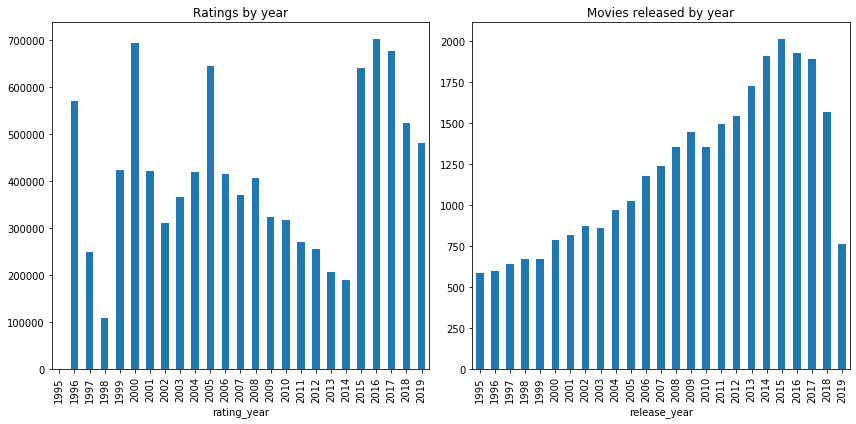

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax1 = merged.groupby('rating_year')['rating'].count().plot(kind='bar', ax=ax[0], title='Ratings by year')

ax2 = number_movies_released.groupby('release_year')['count'].sum().plot(kind='bar', ax=ax[1], title='Movies released by year')
fig.tight_layout()

In [16]:
def count_ratings_by_years(df, start, end):
    
    ratings_count = [0] * 10
    ratings = np.linspace(0.5, 5.0, 10)
    for year in range(start, end + 1):
        df_year = df[df['rating_year'] == year]
        count = 0
        for rating in ratings:
            ratings_count[count] += (df_year[df_year['rating'] == rating]['movieId'].count())
            count += 1
    return ratings_count

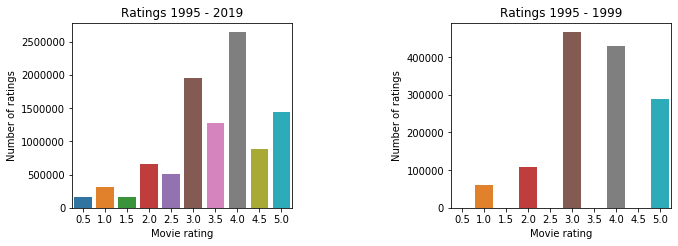

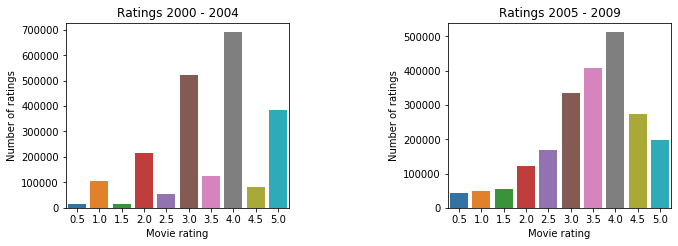

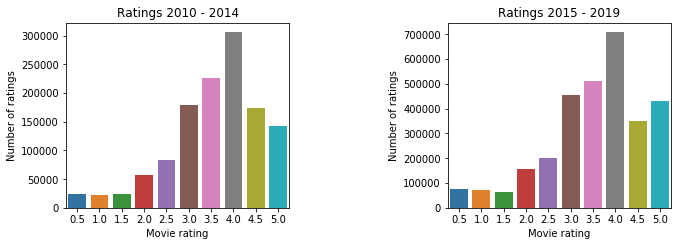

In [112]:
keys = np.linspace(0.5, 5.0, 10)
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax1 = sns.barplot(keys, count_ratings_by_years(merged, 1995, 2019), ax=ax[0])
ax1.set_title('Ratings 1995 - 2019')
ax1.set(xlabel='Movie rating', ylabel='Number of ratings')

ax2 = sns.barplot(keys, count_ratings_by_years(merged, 1995, 1999), ax=ax[1])
ax2.set_title('Ratings 1995 - 1999')
ax2.set(xlabel='Movie rating', ylabel='Number of ratings')
fig.tight_layout(pad=10.0)

fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax3 = sns.barplot(keys, count_ratings_by_years(merged, 2000, 2004), ax=ax[0])
ax3.set_title('Ratings 2000 - 2004')
ax3.set(xlabel='Movie rating', ylabel='Number of ratings')

ax4 = sns.barplot(keys, count_ratings_by_years(merged, 2005, 2009), ax=ax[1])
ax4.set_title('Ratings 2005 - 2009')
ax4.set(xlabel='Movie rating', ylabel='Number of ratings')
fig.tight_layout(pad=10.0)

fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax5 = sns.barplot(keys, count_ratings_by_years(merged, 2010, 2014), ax=ax[0])
ax5.set_title('Ratings 2010 - 2014')
ax5.set(xlabel='Movie rating', ylabel='Number of ratings')

ax6 = sns.barplot(keys, count_ratings_by_years(merged, 2015, 2019), ax=ax[1])
ax6.set_title('Ratings 2015 - 2019')
ax6.set(xlabel='Movie rating', ylabel='Number of ratings')

fig.tight_layout(pad=10.0)

#### Checking the sequence of user and movie ids

In [18]:
merged['userId'].min(), merged['userId'].max(), merged['userId'].nunique()

(1, 162541, 162541)

In [19]:
merged['movieId'].min(), merged['movieId'].max(), merged['movieId'].nunique()

(1, 209171, 48213)

We see above that the user ids are sequential, while the movie ids on the other hand are not. Later in the model building phase,
the movie ids will need to be re-indexed. This will ensure no unnecessary space is used when the movie matrix is created for example. At the same time we will need to keep track of the original movie ids for when predictions need to be made.

In [20]:
merged['genre_count'] = merged['genres'].apply(lambda genres: len(genres.split('|')))

In [45]:
movie_genres = []
merged['genres'].apply(lambda genres: movie_genres.extend(genres.split('|')))
movie_genres = sorted(set(movie_genres))

In [91]:
def get_genre_count(number_of_genres, movie_genres, df):
    
    genre_count = [0] * len(movie_genres)
    for index, genres in df[df['genre_count'] == number_of_genres]['genres'].items():
        for genre in genres.split('|'):
            genre_count[movie_genres.index(genre)] += 1
            
    return genre_count

In [54]:
merged['genre_count'].min(), merged['genre_count'].max()

(1, 10)

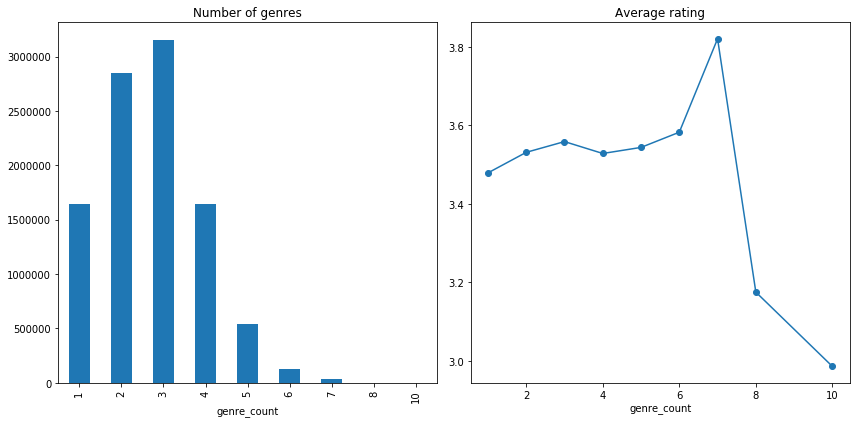

In [44]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax1 = merged.groupby('genre_count')['rating'].count().plot(kind='bar', title='Number of genres', ax=ax[0])
ax2 = merged.groupby('genre_count')['rating'].mean().plot(kind='line', marker='o', title='Average rating', ax=ax[1])

fig.tight_layout()

<BarContainer object of 20 artists>

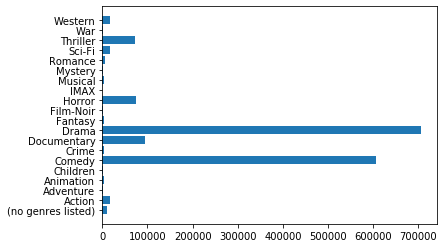

In [115]:
plt.barh(movie_genres, get_genre_count(1, movie_genres, merged))

<BarContainer object of 20 artists>

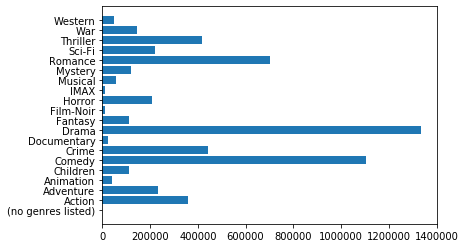

In [116]:
plt.barh(movie_genres, get_genre_count(2, movie_genres, merged))

<BarContainer object of 20 artists>

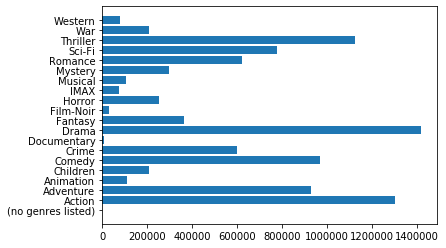

In [117]:
plt.barh(movie_genres, get_genre_count(3, movie_genres, merged))

<BarContainer object of 20 artists>

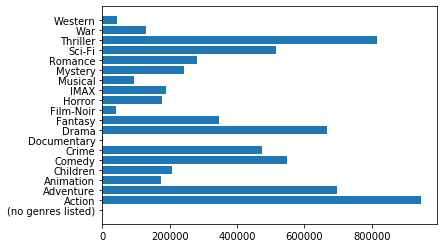

In [118]:
plt.barh(movie_genres, get_genre_count(4, movie_genres, merged))

In [164]:
decades = [(1870, 1879), (1880, 1889), (1990, 1909), (1910, 1919), (1920, 1929),
           (1930, 1939), (1940, 1949), (1950, 1959), (1960, 1969), (1970, 1979),
           (1980, 1989), (1990, 1999), (2000, 2009), (2010, 2019), (9999, 10000)]

decade_categories = ['1870s', '1880s', '1890s', '1900s', '1910s', '1920s', '1930s', '1940',
           '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', 'Unspecified']

def movie_rating_decade_released(start_year, end_year, decades, df):
    
    ratings_count = []
    ratings_average = []
    
    for start, end in decades:
        mask_1 = (df['release_year'] >= start) & (df['release_year'] <= end)
        mask_2 = (df['rating_year'] >= start_year) & (df['rating_year'] <= end_year)
        sub_df = df[mask_1 & mask_2]['rating']
        ratings_count.append(sub_df.count())
        ratings_average.append(np.round(sub_df.mean(), 2))
    
    return ratings_count, ratings_average

In [165]:
count, average = movie_rating_decade_released(1995, 2019, decades, merged)
decades_df = pd.DataFrame(list(zip(decade_categories, count, average)), columns=['decade', 'ratings_count', 'ratings_average']).fillna(0)
decades_df

,decade,ratings_count,ratings_average
0,1870s,8,2.69
1,1880s,32,2.50
2,1890s,0,0.00
3,1900s,1143,3.22
4,1910s,15258,3.80
5,1920s,77681,3.80
6,1930s,121646,3.87
7,1940,198803,3.85
8,1950s,293647,3.80
9,1960s,507445,3.77


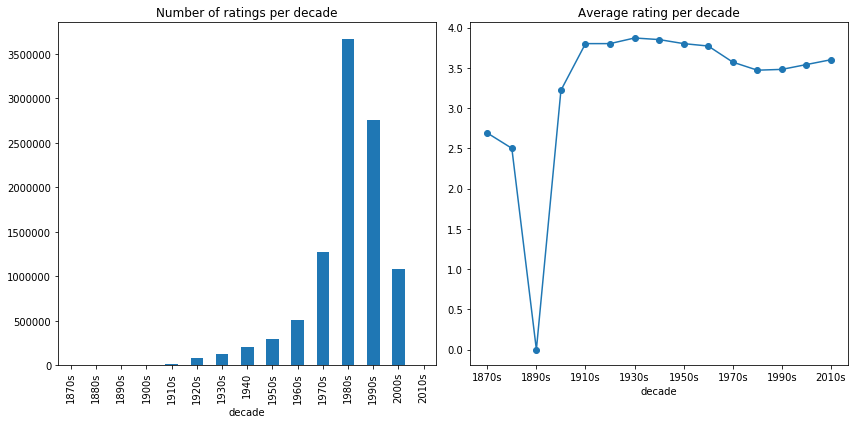

In [166]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax1 = decades_df.groupby('decade')['ratings_count'].sum().plot(kind='bar', title='Number of ratings per decade', ax=ax[0])
ax2 = decades_df.groupby('decade')['ratings_average'].sum().plot(kind='line', marker='o', title='Average rating per decade', ax=ax[1])

fig.tight_layout()

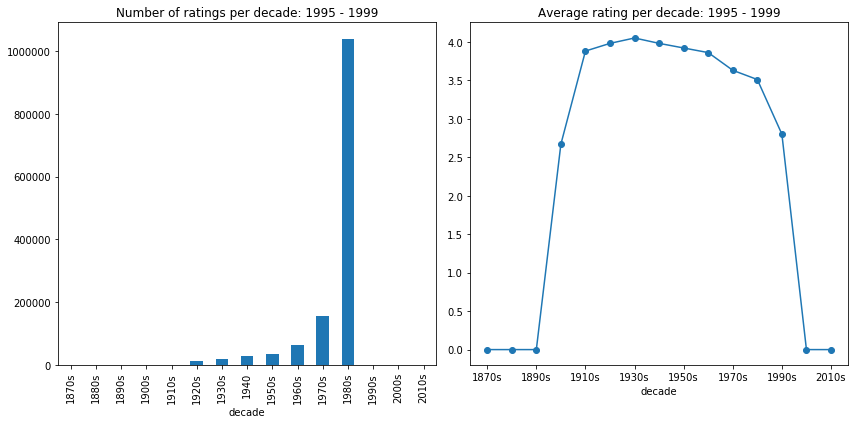

In [167]:
count, average = movie_rating_decade_released(1995, 1999, decades, merged)
decades_df = pd.DataFrame(list(zip(decade_categories, count, average)), columns=['decade', 'ratings_count', 'ratings_average']).fillna(0)

fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax1 = decades_df.groupby('decade')['ratings_count'].sum().plot(kind='bar', title='Number of ratings per decade: 1995 - 1999', ax=ax[0])
ax2 = decades_df.groupby('decade')['ratings_average'].sum().plot(kind='line', marker='o', title='Average rating per decade: 1995 - 1999', ax=ax[1])

fig.tight_layout()

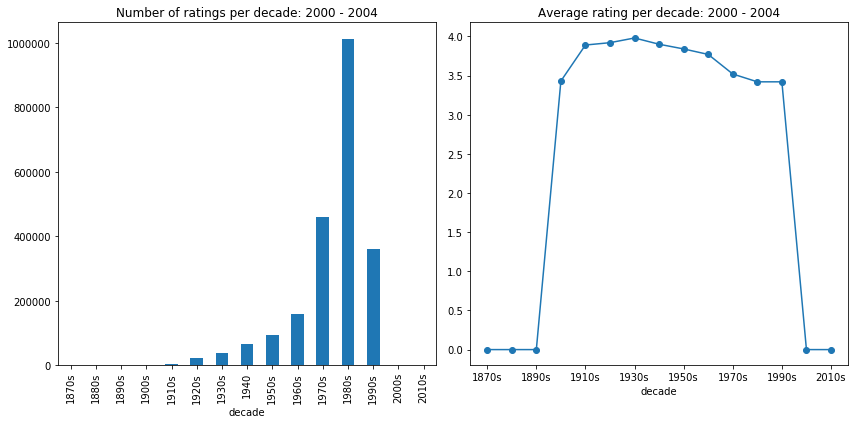

In [168]:
count, average = movie_rating_decade_released(2000, 2004, decades, merged)
decades_df = pd.DataFrame(list(zip(decade_categories, count, average)), columns=['decade', 'ratings_count', 'ratings_average']).fillna(0)

fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax1 = decades_df.groupby('decade')['ratings_count'].sum().plot(kind='bar', title='Number of ratings per decade: 2000 - 2004', ax=ax[0])
ax2 = decades_df.groupby('decade')['ratings_average'].sum().plot(kind='line', marker='o', title='Average rating per decade: 2000 - 2004', ax=ax[1])

fig.tight_layout()

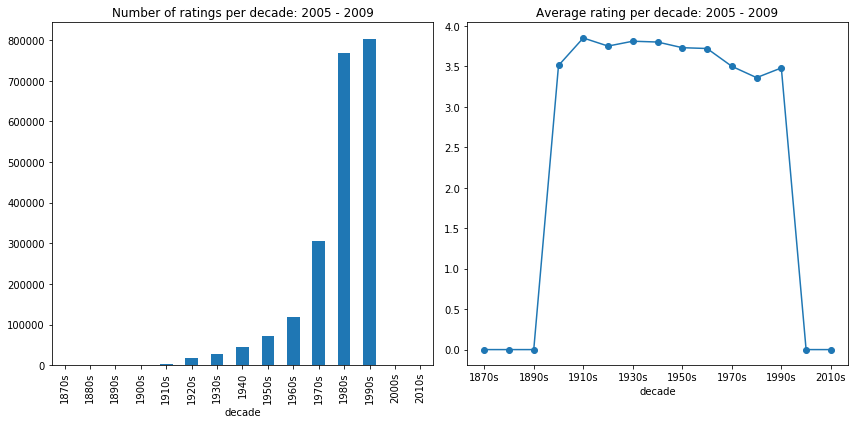

In [169]:
count, average = movie_rating_decade_released(2005, 2009, decades, merged)
decades_df = pd.DataFrame(list(zip(decade_categories, count, average)), columns=['decade', 'ratings_count', 'ratings_average']).fillna(0)

fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax1 = decades_df.groupby('decade')['ratings_count'].sum().plot(kind='bar', title='Number of ratings per decade: 2005 - 2009', ax=ax[0])
ax2 = decades_df.groupby('decade')['ratings_average'].sum().plot(kind='line', marker='o', title='Average rating per decade: 2005 - 2009', ax=ax[1])

fig.tight_layout()

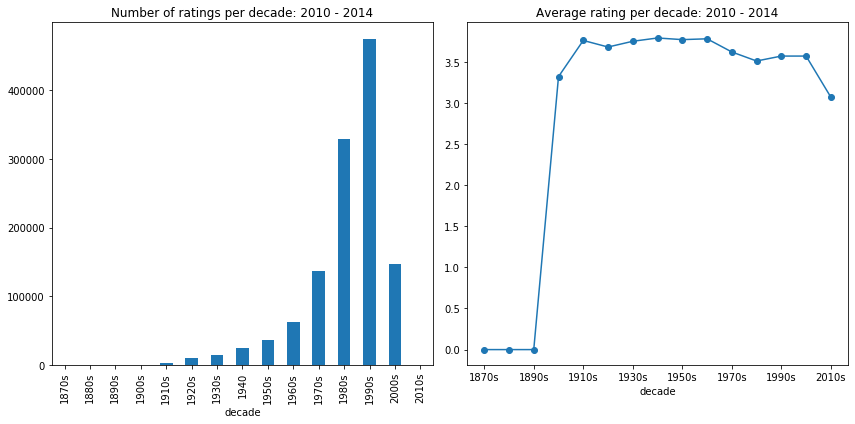

In [170]:
count, average = movie_rating_decade_released(2010, 2014, decades, merged)
decades_df = pd.DataFrame(list(zip(decade_categories, count, average)), columns=['decade', 'ratings_count', 'ratings_average']).fillna(0)

fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax1 = decades_df.groupby('decade')['ratings_count'].sum().plot(kind='bar', title='Number of ratings per decade: 2010 - 2014', ax=ax[0])
ax2 = decades_df.groupby('decade')['ratings_average'].sum().plot(kind='line', marker='o', title='Average rating per decade: 2010 - 2014', ax=ax[1])

fig.tight_layout()

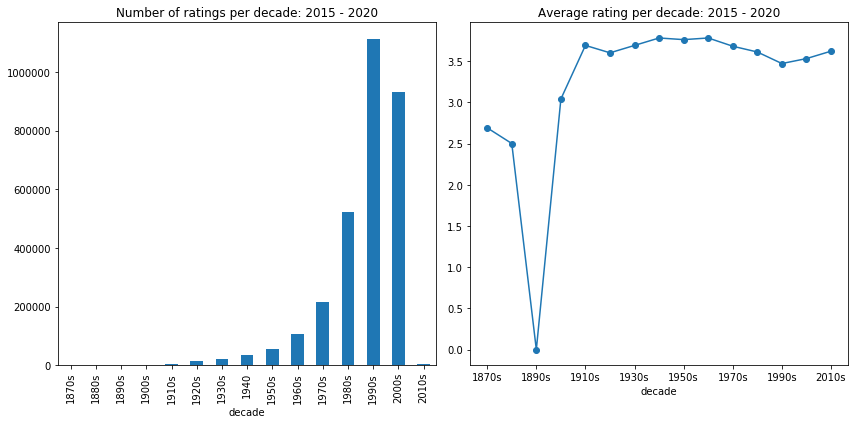

In [171]:
count, average = movie_rating_decade_released(2015, 2020, decades, merged)
decades_df = pd.DataFrame(list(zip(decade_categories, count, average)), columns=['decade', 'ratings_count', 'ratings_average']).fillna(0)

fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax1 = decades_df.groupby('decade')['ratings_count'].sum().plot(kind='bar', title='Number of ratings per decade: 2015 - 2020', ax=ax[0])
ax2 = decades_df.groupby('decade')['ratings_average'].sum().plot(kind='line', marker='o', title='Average rating per decade: 2015 - 2020', ax=ax[1])

fig.tight_layout()

Analysis will centre around revenue cost for having movies on catalogue, showing users movies they don't want see - brand affinity, computational resources and the expense thereof.